In [1]:
# Cell 0: Cài đặt Môi trường
# Chạy cell này, sau đó BẮT BUỘC "Runtime" -> "Restart session" (Khởi động lại phiên)

from google.colab import drive
import os
import sys

print(f"Phiên Google Drive đang kết nối tại: /content/drive")
drive.mount('/content/drive', force_remount=False)

print("\n⏳ Đang cài đặt các thư viện cần thiết...")

# Gỡ cài đặt moviepy cũ (nếu có) và cài bản 1.0.3 ổn định
!pip uninstall -y moviepy
!pip install moviepy==1.0.3

# Cài đặt Whisper, TensorFlow (cho YAMNet), và các thư viện xử lý
!pip install -U openai-whisper
!pip install -U tensorflow tensorflow_hub librosa matplotlib pandas

print("\n" + "="*40)
print("✅ CÀI ĐẶT HOÀN TẤT (LẦN 1).")
print("💡 BÂY GIỜ HÃY CHẠY: 'Runtime' -> 'Restart session' (Khởi động lại phiên)")
print("💡 SAU KHI KHỞI ĐỘNG LẠI, HÃY CHẠY LẠI CELL NÀY LẦN NỮA.")
print("="*40 + "\n")

# --- Khối kiểm tra sau khi khởi động lại ---
try:
    import torch
    import tensorflow as tf
    import moviepy.editor
    print("\n✅✅✅ THÀNH CÔNG! Import (torch, tensorflow, moviepy) thành công.")

    # Kiểm tra GPU
    if torch.cuda.is_available():
        print("✅ GPU đã sẵn sàng cho PyTorch (Whisper).")
    else:
        print("⚠️ Lưu ý: Không tìm thấy GPU cho PyTorch (Whisper).")

    if tf.config.list_physical_devices('GPU'):
        print("✅ GPU đã sẵn sàng cho TensorFlow (YAMNet).")
    else:
        print("⚠️ Lưu ý: Không tìm thấy GPU cho TensorFlow (YAMNet).")

except ImportError as e:
    print(f"\n❌ LỖI KHI IMPORT: {e}")
    print("💡 Vui lòng đảm bảo bạn đã 'Restart session' và chạy lại cell này.")

Phiên Google Drive đang kết nối tại: /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

⏳ Đang cài đặt các thư viện cần thiết...
Found existing installation: moviepy 1.0.3
Uninstalling moviepy-1.0.3:
  Successfully uninstalled moviepy-1.0.3
  Using cached moviepy-1.0.3-py3-none-any.whl
  Using cached tensorflow-2.20.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.5 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)

✅ CÀI ĐẶT HOÀN TẤT (LẦN 1).
💡 BÂY GIỜ HÃY CHẠY: 'Runtime' -> 'Restart session' (Khởi động lại phiên)
💡 SAU KHI KHỞI ĐỘNG LẠI, HÃY CHẠY LẠI CELL NÀY LẦN NỮA.


✅✅✅ THÀNH CÔNG! Import (torch, tensorflow, moviepy) thành công.
✅ GPU đã sẵn sàng cho PyTorch (Whisper).
✅ GPU đã sẵn sàng cho TensorFlow (YAMNet).


In [2]:
!apt-get update
!apt-get install -y imagemagick
# Sửa file policy để cho phép ImageMagick đọc/ghi (mặc định trên Colab bị tắt)
!sed -i 's/none/read,write/g' /etc/ImageMagick-6/policy.xml

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [3]:
# Cell 1: Imports và Cấu hình (An toàn để chạy lại nhiều lần)

import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip, TextClip, CompositeVideoClip
import whisper
import tensorflow as tf
import tensorflow_hub as hub
from google.colab import files
import os
import gc
import time # Add this line to import the time module


# --- ⚙️ CẤU HÌNH DỰ ÁN (CHỈNH SỬA Ở ĐÂY) ---

# 1. Đường dẫn file video của bạn trên Google Drive
VIDEO_PATH_IN_DRIVE = "/content/drive/MyDrive/input_video.mp4" # !!! THAY ĐỔI ĐƯỜNG DẪN NÀY !!!

# 2. Thư mục lưu kết quả trên Google Drive
OUTPUT_FOLDER = "/content/drive/MyDrive/VideoCaptionOutput" # !!! THAY ĐỔI NẾU MUỐN !!!

# 3. Cấu hình Whisper
WHISPER_MODEL_NAME = "base" # "tiny", "base", "small", "medium", "large"

# 4. Cấu hình YAMNet
# Ngưỡng tin cậy (0.0 - 1.0) để giữ lại một sự kiện âm thanh
YAMNET_CONFIDENCE_THRESHOLD = 0.15 # 0.3 là một khởi đầu tốt
SPEECH_SUBTITLE_OFFSET_SEC = 0.2
# Các lớp âm thanh môi trường bạn muốn phát hiện
# (Xem danh sách 521 lớp của YAMNet để thêm)
TARGET_EVENT_LABELS = [
    'Laughter', 'Clap', 'Clapping', 'Bird', 'Birdsong',
    'Rain', 'Thunderstorm', 'Music'
]
# Thời lượng tối thiểu (giây) của một sự kiện để giữ lại
MIN_EVENT_DURATION_SEC = 0.2

# 5. Cấu hình Video Output (Tùy chọn)
# Đặt thành True nếu bạn muốn chạy bước 14 (tốn thời gian)
RUN_VIDEO_OVERLAY = False

# --- Tự động tạo đường dẫn và thư mục ---
BASE_FILENAME = os.path.splitext(os.path.basename(VIDEO_PATH_IN_DRIVE))[0]
TEMP_AUDIO_PATH = "temp_extracted_audio.wav"
OUTPUT_SRT_PATH = os.path.join(OUTPUT_FOLDER, f"{BASE_FILENAME}_final.srt")
OUTPUT_VIDEO_PATH = os.path.join(OUTPUT_FOLDER, f"{BASE_FILENAME}_captioned.mp4")

os.makedirs(OUTPUT_FOLDER, exist_ok=True)
print("✅ Imports và cấu hình đã sẵn sàng.")
print(f"🎬 Video đầu vào: {VIDEO_PATH_IN_DRIVE}")
print(f"💾 Thư mục Output: {OUTPUT_FOLDER}")

✅ Imports và cấu hình đã sẵn sàng.
🎬 Video đầu vào: /content/drive/MyDrive/input_video.mp4
💾 Thư mục Output: /content/drive/MyDrive/VideoCaptionOutput


In [4]:
# Cell 2: Tách Âm thanh từ Video

audio_path_for_processing = None

if not os.path.exists(VIDEO_PATH_IN_DRIVE):
    print(f"❌ LỖI: Không tìm thấy video tại: {VIDEO_PATH_IN_DRIVE}")
else:
    print(f"⏳ Đang tách âm thanh từ video...")
    start_time = time.time()
    try:
        with VideoFileClip(VIDEO_PATH_IN_DRIVE) as video:
            video.audio.write_audiofile(TEMP_AUDIO_PATH, codec='pcm_s16le', logger=None)
        audio_path_for_processing = TEMP_AUDIO_PATH
        end_time = time.time()
        print(f"✅ Đã tách âm thanh thành công: {audio_path_for_processing} ({end_time - start_time:.2f} giây)")
    except Exception as e:
        print(f"❌ Lỗi khi tách âm thanh: {e}")

if 'video' in locals():
    del video
    gc.collect()

⏳ Đang tách âm thanh từ video...
✅ Đã tách âm thanh thành công: temp_extracted_audio.wav (2.81 giây)


In [5]:
# Cell 3: Chạy Whisper (Phụ đề Lời nói)

speech_segments = []
use_fp16_whisper = torch.cuda.is_available()

if audio_path_for_processing:
    print(f"⏳ Đang tải model Whisper ({WHISPER_MODEL_NAME})...")
    start_time = time.time()
    try:
        model_whisper = whisper.load_model(WHISPER_MODEL_NAME)
        print("✅ Model Whisper đã tải xong.")

        print("🤖 Đang chạy Whisper transcribe...")
        result_whisper = model_whisper.transcribe(audio_path_for_processing, fp16=use_fp16_whisper)
        raw_segments = result_whisper['segments']

        # Định dạng lại kết quả cho sạch
        speech_segments = [
    {
        'start': s['start'] + SPEECH_SUBTITLE_OFFSET_SEC,
        'end': s['end'] + SPEECH_SUBTITLE_OFFSET_SEC,
        'text': s['text'].strip()
    }
    for s in raw_segments if s['text'].strip()
]

        end_time = time.time()
        print(f"💬 Whisper hoàn tất, nhận diện {len(speech_segments)} đoạn hội thoại ({end_time - start_time:.2f} giây).")

    except Exception as e:
        print(f"❌ Lỗi khi chạy Whisper: {e}")
        speech_segments = []
    finally:
        if 'model_whisper' in locals(): del model_whisper
        if torch.cuda.is_available(): torch.cuda.empty_cache()
else:
    print("⚠️ Không có file audio để xử lý Whisper.")

⏳ Đang tải model Whisper (base)...


100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 81.2MiB/s]


✅ Model Whisper đã tải xong.
🤖 Đang chạy Whisper transcribe...
💬 Whisper hoàn tất, nhận diện 38 đoạn hội thoại (25.01 giây).


In [6]:
# Cell 4: "Đánh giá" Whisper (Kiểm tra chất lượng)
# (Đây là bước đánh giá định tính, không có ground truth)

# Hàm format_time_srt (cần cho cell này và Cell 11)
def format_time_srt(seconds):
    if seconds < 0: seconds = 0
    ms = int((seconds - int(seconds)) * 1000)
    s = int(seconds); m, s = divmod(s, 60); h, m = divmod(m, 60)
    return f"{h:02d}:{m:02d}:{s:02d},{ms:03d}"


if speech_segments:
    print("--- 10 đoạn hội thoại đầu tiên Whisper nhận diện ---")
    for i, seg in enumerate(speech_segments[:10]):
        start_time_str = format_time_srt(seg['start'])
        end_time_str = format_time_srt(seg['end'])
        print(f"[{start_time_str} --> {end_time_str}] {seg['text']}")
else:
    print("⚠️ Không có kết quả Whisper để hiển thị.")

--- 10 đoạn hội thoại đầu tiên Whisper nhận diện ---
[00:00:00,200 --> 00:00:02,200] Excuse me?
[00:00:02,200 --> 00:00:04,200] Excuse me?
[00:00:04,200 --> 00:00:06,200] Sorry.
[00:00:06,200 --> 00:00:08,199] Do you speak English?
[00:00:08,199 --> 00:00:10,199] No, I don't. Sorry.
[00:00:10,199 --> 00:00:12,199] My car's broken down,
[00:00:12,199 --> 00:00:16,199] and I wondered if you could tell me where to find a garage.
[00:00:16,199 --> 00:00:18,199] Well, you know, that's wasted on me.
[00:00:18,199 --> 00:00:20,199] I don't understand what you're saying.
[00:00:20,199 --> 00:00:22,199] I don't speak any English at all.


In [7]:
# Cell 5 (ĐÃ SỬA LỖI): Tải Model YAMNet

import pandas as pd # Đảm bảo pandas được import
import tensorflow_hub as hub # Đảm bảo hub được import

yamnet_model = None
yamnet_class_names = []

print("⏳ Đang tải model YAMNet từ TensorFlow Hub...")
start_time = time.time()
try:
    yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
    yamnet_model = hub.load(yamnet_model_handle)

    # Tải file map tên lớp
    class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')

    # --- SỬA LỖI Ở ĐÂY ---
    # Dùng pandas để đọc file CSV, tự động bỏ qua dòng tiêu đề
    class_map_csv = pd.read_csv(class_map_path)

    # Lấy danh sách tên lớp từ cột 'display_name'
    yamnet_class_names = class_map_csv['display_name'].tolist()
    # --- KẾT THÚC SỬA LỖI ---

    end_time = time.time()
    # Lần này sẽ in ra 521 lớp
    print(f"✅ YAMNet đã tải xong ({end_time - start_time:.2f} giây). Có {len(yamnet_class_names)} lớp âm thanh.")
except Exception as e:
    print(f"❌ Lỗi khi tải YAMNet: {e}")

⏳ Đang tải model YAMNet từ TensorFlow Hub...
✅ YAMNet đã tải xong (3.50 giây). Có 521 lớp âm thanh.


In [8]:
# Cell 6: Chạy YAMNet Inference (Chi tiết)

yamnet_scores_df = None
yamnet_spectrogram = None
audio_waveform = None
SR_YAMNET = 16000 # YAMNet yêu cầu 16kHz

if audio_path_for_processing and yamnet_model:
    print(f"⏳ Đang chạy YAMNet inference trên {audio_path_for_processing}...")
    try:
        # Tải và resample audio về 16kHz
        audio_waveform, sr_orig = librosa.load(audio_path_for_processing, sr=SR_YAMNET, mono=True)
        print(f"✅ Audio đã tải và resample về {SR_YAMNET}Hz.")

        # Chạy model trên toàn bộ waveform
        # Model trả về: scores, embeddings, và log-mel spectrogram
        scores, embeddings, spectrogram = yamnet_model(audio_waveform)

        # Chuyển scores thành DataFrame (bước quan trọng để bảo trì và đánh giá)
        yamnet_scores_df = pd.DataFrame(scores.numpy(), columns=yamnet_class_names)
        yamnet_spectrogram = spectrogram.numpy()

        print(f"✅ YAMNet inference hoàn tất. Kết quả shape: {yamnet_scores_df.shape}")

    except Exception as e:
        print(f"❌ Lỗi khi chạy YAMNet inference: {e}")
else:
    print("⚠️ Bỏ qua YAMNet inference do thiếu audio hoặc model.")

⏳ Đang chạy YAMNet inference trên temp_extracted_audio.wav...
✅ Audio đã tải và resample về 16000Hz.
✅ YAMNet inference hoàn tất. Kết quả shape: (183, 521)


📈 Đang tạo biểu đồ đánh giá YAMNet...


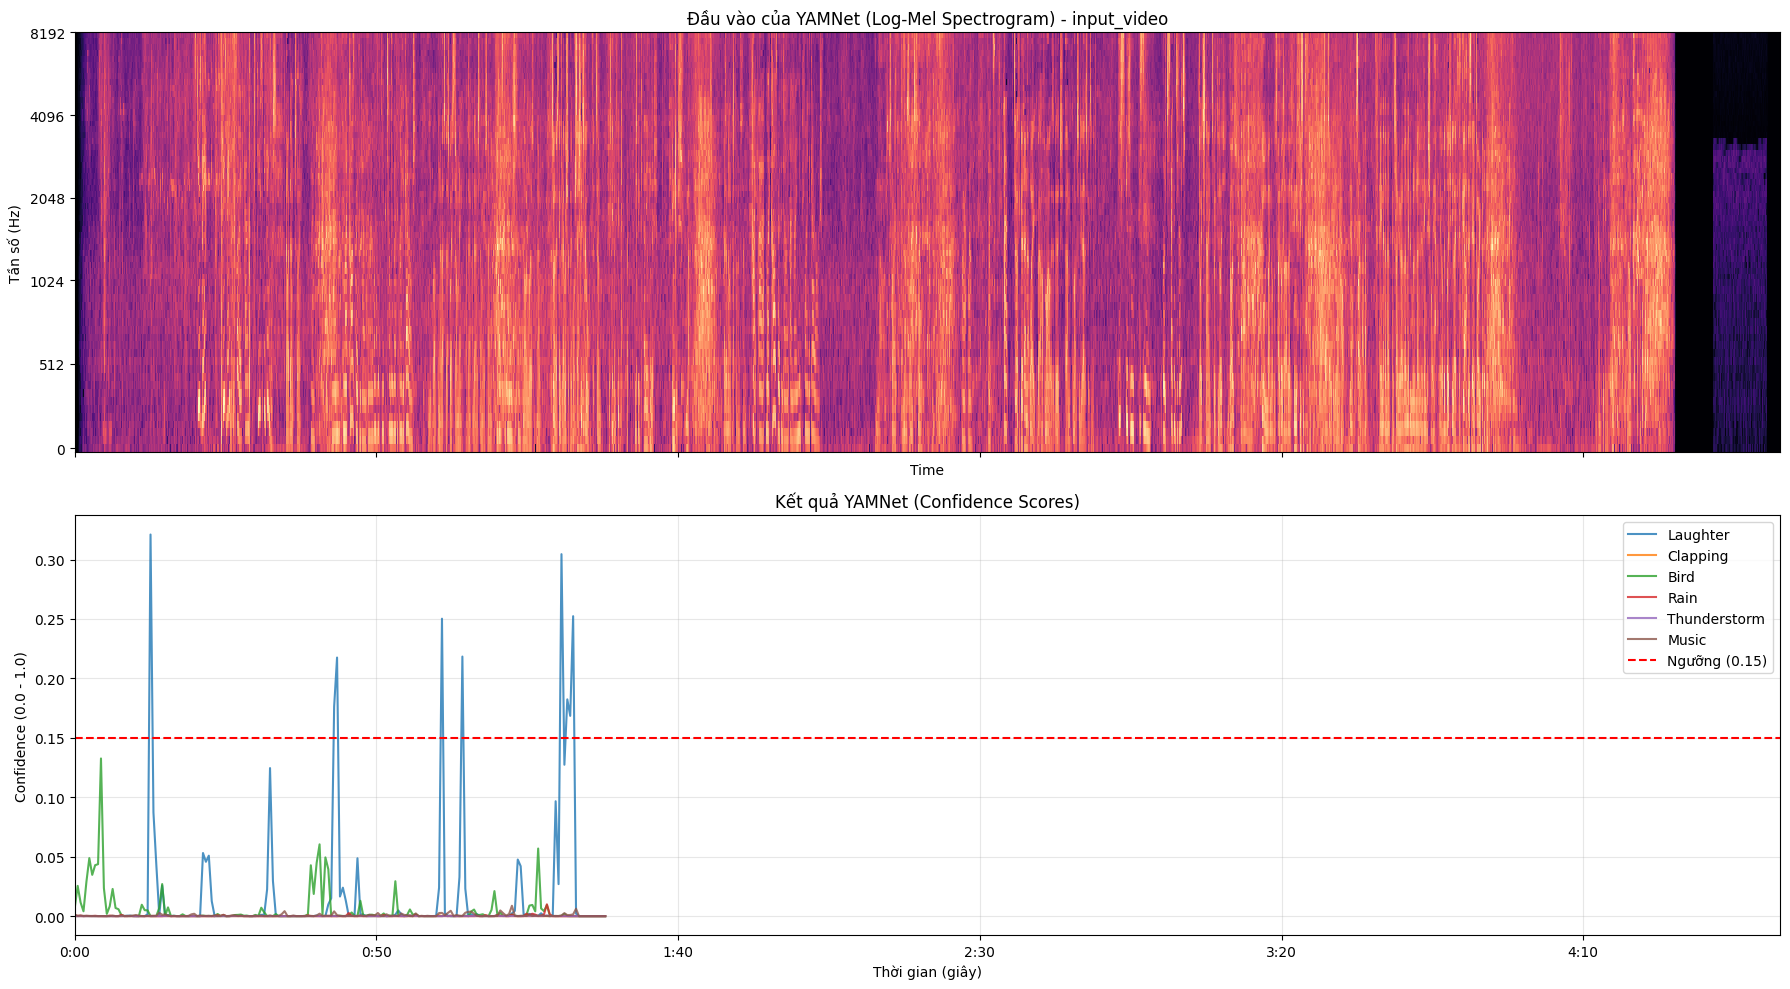

In [9]:
# Cell 7: "Đánh giá" YAMNet (Trực quan hóa)
# Đây là bước đánh giá chi tiết bạn yêu cầu, tương tự như plot training

if yamnet_scores_df is not None and yamnet_spectrogram is not None and audio_waveform is not None:
    print("📈 Đang tạo biểu đồ đánh giá YAMNet...")

    # Lấy thời gian thực tế cho trục X
    duration_sec = len(audio_waveform) / SR_YAMNET
    # YAMNet trả về 1 score cho mỗi 0.48 giây
    time_indices_scores = np.linspace(0, duration_sec, yamnet_scores_df.shape[0])

    # SỬA LỖI: Sử dụng librosa.times_like để tạo trục thời gian cho spectrogram,
    # đảm bảo khớp với số frame của spectrogram.
    # Mặc dù không biết chính xác hop_length của YAMNet, default 512 ở SR 16k thường hoạt động.
    # Dựa trên shape của spectrogram, librosa.times_like sẽ tính toán đúng.
    time_indices_spec = librosa.times_like(yamnet_spectrogram, sr=SR_YAMNET, axis=0)


    # Lọc ra các lớp mục tiêu có trong DataFrame
    target_labels_found = [label for label in TARGET_EVENT_LABELS if label in yamnet_scores_df.columns]

    if not target_labels_found:
        print("⚠️ Không tìm thấy lớp mục tiêu nào trong kết quả YAMNet để vẽ.")
    else:
        fig, axs = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

        # --- Plot 1: Log-Mel Spectrogram (Input của YAMNet) ---
        axs[0].set_title(f"Đầu vào của YAMNet (Log-Mel Spectrogram) - {BASE_FILENAME}")
        # SỬA LỖI: Đảm bảo trục x_coords có cùng số điểm với số cột của spectrogram
        # librosa.times_like đã giải quyết vấn đề này
        librosa.display.specshow(yamnet_spectrogram.T, sr=SR_YAMNET,
                                 x_coords=time_indices_spec,
                                 y_axis='mel', x_axis='time', cmap='magma', ax=axs[0])
        axs[0].set_ylabel("Tần số (Hz)")

        # --- Plot 2: Confidence Scores của các lớp mục tiêu ---
        axs[1].set_title("Kết quả YAMNet (Confidence Scores)")
        for label in target_labels_found:
            axs[1].plot(time_indices_scores, yamnet_scores_df[label], label=label, alpha=0.8)

        # Vẽ đường ngưỡng
        axs[1].axhline(y=YAMNET_CONFIDENCE_THRESHOLD, color='r', linestyle='--', label=f'Ngưỡng ({YAMNET_CONFIDENCE_THRESHOLD})')

        axs[1].set_xlabel("Thời gian (giây)")
        axs[1].set_ylabel("Confidence (0.0 - 1.0)")
        axs[1].legend(loc='upper right')
        axs[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
else:
    print("⚠️ Không có dữ liệu YAMNet để vẽ biểu đồ.")

In [10]:
# Cell 8: Xử lý Kết quả YAMNet (Gộp sự kiện)

audio_events = []

def process_yamnet_events(scores_df, class_names, target_labels, threshold, min_duration_sec, sr=16000):
    """Xử lý DataFrame scores, lọc và gộp các sự kiện liên tiếp."""
    processed_events = []
    scores_step_sec = 0.48 # YAMNet trả về 1 score mỗi 0.48 giây

    target_labels_found = [label for label in target_labels if label in scores_df.columns]
    if not target_labels_found:
        return processed_events

    # Lọc các frame có confidence cao cho các lớp mục tiêu
    high_confidence_frames = scores_df[target_labels_found] > threshold

    current_event = None

    for i in range(len(high_confidence_frames)):
        frame_start_sec = i * scores_step_sec
        frame_end_sec = frame_start_sec + scores_step_sec

        # Lấy lớp có score cao nhất trong các lớp mục tiêu TẠI frame này
        top_event_this_frame = None
        if high_confidence_frames.iloc[i].any(): # Nếu có bất kỳ sự kiện nào vượt ngưỡng
            top_event_label = scores_df[target_labels_found].iloc[i].idxmax()
            # Bỏ qua 'Speech' nếu nó không phải là mục tiêu chính (Whisper đã làm tốt hơn)
            if top_event_label == 'Speech' and 'Speech' not in TARGET_EVENT_LABELS:
                 pass # Bỏ qua
            else:
                 top_event_this_frame = f"[{top_event_label.capitalize()}]"

        if top_event_this_frame:
            if current_event is None:
                # Bắt đầu sự kiện mới
                current_event = {'start': frame_start_sec, 'end': frame_end_sec, 'text': top_event_this_frame}
            elif current_event['text'] == top_event_this_frame:
                # Gộp sự kiện: kéo dài thời gian kết thúc
                current_event['end'] = frame_end_sec
            else:
                # Sự kiện cũ kết thúc, sự kiện mới bắt đầu
                if current_event['end'] - current_event['start'] >= min_duration_sec:
                    processed_events.append(current_event)
                current_event = {'start': frame_start_sec, 'end': frame_end_sec, 'text': top_event_this_frame}
        else:
            # Không có sự kiện nào vượt ngưỡng, kết thúc sự kiện hiện tại (nếu có)
            if current_event is not None:
                if current_event['end'] - current_event['start'] >= min_duration_sec:
                    processed_events.append(current_event)
                current_event = None

    # Thêm sự kiện cuối cùng nếu có
    if current_event is not None and current_event['end'] - current_event['start'] >= min_duration_sec:
        processed_events.append(current_event)

    return processed_events

# --- Chạy hàm xử lý ---
if yamnet_scores_df is not None:
    print("⏳ Đang xử lý và gộp các sự kiện YAMNet...")
    audio_events = process_yamnet_events(
        yamnet_scores_df,
        yamnet_class_names,
        TARGET_EVENT_LABELS,
        YAMNET_CONFIDENCE_THRESHOLD,
        MIN_EVENT_DURATION_SEC,
        SR_YAMNET
    )
    print(f"✅ YAMNet đã phát hiện và gộp {len(audio_events)} sự kiện.")

    # In 10 sự kiện đầu tiên
    print("\n--- 10 sự kiện môi trường đầu tiên ---")
    for evt in audio_events[:10]:
        start_str = format_time_srt(evt['start'])
        end_str = format_time_srt(evt['end'])
        print(f"[{start_str} --> {end_str}] {evt['text']}")
else:
    print("⚠️ Không có dữ liệu YAMNet để xử lý.")

⏳ Đang xử lý và gộp các sự kiện YAMNet...
✅ YAMNet đã phát hiện và gộp 6 sự kiện.

--- 10 sự kiện môi trường đầu tiên ---
[00:00:12,480 --> 00:00:12,960] [Laughter]
[00:00:42,719 --> 00:00:43,679] [Laughter]
[00:01:00,479 --> 00:01:00,959] [Laughter]
[00:01:03,839 --> 00:01:04,319] [Laughter]
[00:01:20,159 --> 00:01:20,640] [Laughter]
[00:01:21,119 --> 00:01:22,560] [Laughter]


In [11]:
# Cell 8.5 (Cell Gỡ lỗi MỚI)
# CHẠY CELL NÀY NGAY SAU KHI CHẠY CELL 8

print("--- KIỂM TRA KẾT QUẢ YAMNET (CHƯA GỘP) ---")

if 'yamnet_scores_df' in locals() and yamnet_scores_df is not None:
    # Lọc ra tất cả các frame có 'Laughter' (tiếng cười) trên ngưỡng 0.1
    laughter_frames = yamnet_scores_df[
        (yamnet_scores_df['Laughter'] > YAMNET_CONFIDENCE_THRESHOLD)
    ]

    print(f"Tìm thấy {len(laughter_frames)} 'frame' có tiếng cười (trên ngưỡng {YAMNET_CONFIDENCE_THRESHOLD}).")

    if len(laughter_frames) > 0:
        print("\nCác thời điểm phát hiện tiếng cười (theo frame 0.48s):")
        # In 5 thời điểm đầu tiên
        for i in laughter_frames.index[:5]:
            frame_start_sec = i * 0.48 # 0.48 là bước nhảy của YAMNet
            print(f" - Tại giây {frame_start_sec:.2f} (Confidence: {laughter_frames.loc[i, 'Laughter']:.2f})")

    print("\n--- KIỂM TRA KẾT QUẢ SAU KHI GỘP (TỪ CELL 8) ---")
    if 'audio_events' in locals() and audio_events:
        print(f"Tìm thấy {len(audio_events)} sự kiện đã gộp (từ Cell 8):")
        for evt in audio_events[:10]:
            print(f" - {evt['text']} (từ {evt['start']:.2f}s đến {evt['end']:.2f}s)")
    else:
        print("⚠️ Không tìm thấy sự kiện nào SAU KHI GỘP (Cell 8).")
        print("   (Có thể do 'MIN_EVENT_DURATION_SEC' quá lớn?)")

else:
    print("⚠️ Không có 'yamnet_scores_df'. Hãy chạy lại Cell 6.")

--- KIỂM TRA KẾT QUẢ YAMNET (CHƯA GỘP) ---
Tìm thấy 9 'frame' có tiếng cười (trên ngưỡng 0.15).

Các thời điểm phát hiện tiếng cười (theo frame 0.48s):
 - Tại giây 12.48 (Confidence: 0.32)
 - Tại giây 42.72 (Confidence: 0.18)
 - Tại giây 43.20 (Confidence: 0.22)
 - Tại giây 60.48 (Confidence: 0.25)
 - Tại giây 63.84 (Confidence: 0.22)

--- KIỂM TRA KẾT QUẢ SAU KHI GỘP (TỪ CELL 8) ---
Tìm thấy 6 sự kiện đã gộp (từ Cell 8):
 - [Laughter] (từ 12.48s đến 12.96s)
 - [Laughter] (từ 42.72s đến 43.68s)
 - [Laughter] (từ 60.48s đến 60.96s)
 - [Laughter] (từ 63.84s đến 64.32s)
 - [Laughter] (từ 80.16s đến 80.64s)
 - [Laughter] (từ 81.12s đến 82.56s)


In [12]:
# Cell 9: Gộp Phụ đề (Whisper + YAMNet)

all_subtitles = []

if not speech_segments and not audio_events:
    print("⚠️ Không có phụ đề nào được tạo ra từ Whisper hay YAMNet.")
else:
    print("🔄 Đang gộp và sắp xếp phụ đề...")

    # Gộp danh sách kết quả
    combined_list = speech_segments + audio_events

    # Sắp xếp tất cả theo thời gian bắt đầu
    all_subtitles = sorted(combined_list, key=lambda x: x['start'])
    print(f"✅ Đã gộp và sắp xếp {len(all_subtitles)} phụ đề.")

    # (Tùy chọn) In 10 phụ đề đầu tiên đã gộp
    print("\n--- 10 phụ đề đầu tiên đã gộp ---")
    for sub in all_subtitles[:10]:
        start_str = format_time_srt(sub['start'])
        end_str = format_time_srt(sub['end'])
        print(f"[{start_str} --> {end_str}] {sub['text']}")

🔄 Đang gộp và sắp xếp phụ đề...
✅ Đã gộp và sắp xếp 44 phụ đề.

--- 10 phụ đề đầu tiên đã gộp ---
[00:00:00,200 --> 00:00:02,200] Excuse me?
[00:00:02,200 --> 00:00:04,200] Excuse me?
[00:00:04,200 --> 00:00:06,200] Sorry.
[00:00:06,200 --> 00:00:08,199] Do you speak English?
[00:00:08,199 --> 00:00:10,199] No, I don't. Sorry.
[00:00:10,199 --> 00:00:12,199] My car's broken down,
[00:00:12,199 --> 00:00:16,199] and I wondered if you could tell me where to find a garage.
[00:00:12,480 --> 00:00:12,960] [Laughter]
[00:00:16,199 --> 00:00:18,199] Well, you know, that's wasted on me.
[00:00:18,199 --> 00:00:20,199] I don't understand what you're saying.


In [13]:
# Cell 10: Tạo và Tải về File SRT

if not all_subtitles:
    print("⚠️ Không có phụ đề để ghi ra file SRT.")
else:
    print(f"⏳ Đang tạo file SRT tại: {OUTPUT_SRT_PATH}")
    try:
        with open(OUTPUT_SRT_PATH, 'w', encoding='utf-8') as f:
            for i, sub in enumerate(all_subtitles):
                # Đảm bảo phụ đề có thời lượng tối thiểu
                end_time = max(sub['start'] + 0.1, sub['end'])

                f.write(str(i + 1) + '\n')
                f.write(f"{format_time_srt(sub['start'])} --> {format_time_srt(end_time)}\n")
                f.write(sub['text'] + '\n\n')
        print(f"✅ Đã tạo file SRT thành công!")

        # Cung cấp link tải về
        try:
           files.download(OUTPUT_SRT_PATH)
           print(f"🚀 Bắt đầu tải file '{os.path.basename(OUTPUT_SRT_PATH)}' về máy của bạn...")
        except Exception as download_err:
           print(f"💡 Bạn có thể tải file thủ công từ đường dẫn: {OUTPUT_SRT_PATH}")

    except Exception as e:
        print(f"❌ Lỗi khi ghi file SRT: {e}")

⏳ Đang tạo file SRT tại: /content/drive/MyDrive/VideoCaptionOutput/input_video_final.srt
✅ Đã tạo file SRT thành công!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🚀 Bắt đầu tải file 'input_video_final.srt' về máy của bạn...


In [14]:
# Cell 11: Hàm Overlay Video (Đã sửa lỗi Font và ImageMagick)

from moviepy.editor import VideoFileClip, TextClip, CompositeVideoClip
import os
import time

def overlay_subtitles_on_video(video_path, subtitles, output_path,
                               font='Liberation-Sans', # ĐỔI FONT ĐỂ TRÁNH LỖI TRÊN COLAB
                               speech_fontsize=24, event_fontsize=20):
    """
    Phủ phụ đề lên video gốc.
    """
    if not subtitles:
        print("⚠️ Không có phụ đề để overlay.")
        return
    if not os.path.exists(video_path):
        print(f"❌ LỖI: Video gốc không tồn tại tại {video_path}")
        return

    print(f"🎬 Đang chuẩn bị overlay phụ đề lên video...")
    start_time = time.time()

    try:
        video = VideoFileClip(video_path)
        clips = [video]
        video_width, video_height = video.size

        print(f"🎞️ Video gốc: {video_width}x{video_height}, Duration: {video.duration:.2f}s")
        print(f"💬 Tổng số phụ đề cần overlay: {len(subtitles)}")

        for sub in subtitles:
            start = sub['start']
            end = max(sub['start'] + 0.1, sub['end'])
            duration = end - start
            text = sub['text']

            if start > video.duration: continue
            if end > video.duration:
                duration = video.duration - start
                if duration <= 0: continue

            # Cấu hình giao diện phụ đề
            fontsize = speech_fontsize
            color = 'white'
            bg_color = 'rgba(0, 0, 0, 0.6)'
            position = ('center', 0.9) # Dưới đáy

            # Nếu là sự kiện môi trường (có dấu [])
            if text.startswith('['):
                fontsize = event_fontsize
                color = 'yellow' # Màu vàng cho dễ phân biệt
                bg_color = 'transparent'
                position = ('center', 0.8) # Cao hơn một chút

            try:
                # Tạo TextClip
                text_clip = TextClip(text, fontsize=fontsize, color=color, bg_color=bg_color,
                                     font=font, size=(video_width * 0.85, None),
                                     method='caption', align='center', stroke_color='black', stroke_width=1)

                text_clip = text_clip.set_position(position).set_duration(duration).set_start(start)
                clips.append(text_clip)
            except Exception as clip_err:
                 print(f"⚠️ Lỗi tạo TextClip: '{text}'. Lỗi: {clip_err}")

        if len(clips) > 1:
            print("\n🔄 Đang ghép các clip (Render)...")
            final_video = CompositeVideoClip(clips, size=video.size)

            print(f"💾 Đang xuất video ra file: {output_path}...")
            # Dùng preset ultrafast để render nhanh hơn trên Colab
            final_video.write_videofile(output_path, codec='libx264', audio_codec='aac',
                                        threads=4, preset='ultrafast', fps=24, logger=None)

            end_time = time.time()
            print(f"🎉 Đã tạo video mới thành công ({end_time - start_time:.2f} giây).")
            print(f"Lưu tại: {output_path}")
        else:
            print("⚠️ Không tạo được clip phụ đề nào. Kiểm tra lại ImageMagick.")

    except Exception as e:
        print(f"❌ Lỗi nghiêm trọng khi overlay video: {e}")
    finally:
        # Dọn dẹp bộ nhớ
        if 'video' in locals(): video.close()
        if 'final_video' in locals(): final_video.close()

In [15]:
# Cell 12: (Tùy chọn) Chạy quá trình Overlay Video
# CẢNH BÁO: Cell này có thể chạy RẤT LÂU và tốn nhiều tài nguyên!

# Đặt cờ RUN_VIDEO_OVERLAY thành True trong Cell 1 nếu bạn muốn chạy cell này
if RUN_VIDEO_OVERLAY:
    if all_subtitles and os.path.exists(VIDEO_PATH_IN_DRIVE):
        overlay_subtitles_on_video(
            VIDEO_PATH_IN_DRIVE,
            all_subtitles,
            OUTPUT_VIDEO_PATH,
            font='Arial', # Có thể đổi thành 'Liberation-Sans' nếu Arial lỗi
            speech_fontsize=24,
            event_fontsize=20
        )
    else:
        print("⚠️ Không thể chạy overlay do thiếu phụ đề hoặc video gốc.")
else:
    print("ℹ️ Bỏ qua bước overlay video (RUN_VIDEO_OVERLAY = False trong Cell 1).")

ℹ️ Bỏ qua bước overlay video (RUN_VIDEO_OVERLAY = False trong Cell 1).


In [16]:
# Cell 13: Dọn dẹp File Tạm

print("🧹 Đang dọn dẹp file audio tạm...")
if os.path.exists(TEMP_AUDIO_PATH):
    try:
        os.remove(TEMP_AUDIO_PATH)
        print(f"✅ Đã xóa: {TEMP_AUDIO_PATH}")
    except Exception as e:
        print(f"⚠️ Lỗi khi xóa file tạm: {e}")
else:
    print("☑️ Không tìm thấy file audio tạm để xóa.")

# Giải phóng bộ nhớ
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("✅ Dọn dẹp hoàn tất.")

🧹 Đang dọn dẹp file audio tạm...
✅ Đã xóa: temp_extracted_audio.wav
✅ Dọn dẹp hoàn tất.


# Huấn luyện và Đánh giá Model ESC-50

In [17]:
# Cell 14: Tải và Chuẩn bị Dữ liệu ESC-50 (K-Fold)

import pandas as pd
import os
import requests
import zipfile
import io
from sklearn.preprocessing import LabelEncoder

# --- Tải và giải nén Dataset (nếu chưa có) ---
ESC50_URL = "https://github.com/karolpiczak/ESC-50/archive/master.zip"
DATA_DIR_ESC50 = 'ESC-50-master/audio/'
CSV_PATH_ESC50 = 'ESC-50-master/meta/esc50.csv'

if not os.path.exists('ESC-50-master'):
    print("⏳ Đang tải bộ dữ liệu ESC-50 đầy đủ (khoảng 297 MB)...")
    try:
        r = requests.get(ESC50_URL, stream=True)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall()
        print("✅ Đã tải và giải nén xong ESC-50.")
    except Exception as e:
        print(f"❌ Lỗi khi tải ESC-50: {e}")
else:
    print("☑️ Bộ dữ liệu ESC-50 đã tồn tại.")

# --- Đọc CSV và chuẩn bị cho Cross-Validation ---
df_esc50_full = None
if os.path.exists(CSV_PATH_ESC50):
    df_esc50_full = pd.read_csv(CSV_PATH_ESC50)
    print(f"\n📊 Đã tải file meta. Tổng số file âm thanh: {len(df_esc50_full)}")
    print(f"🔢 Tổng số lớp: {df_esc50_full['category'].nunique()}")
    print(f"📁 Dữ liệu được chia sẵn thành {df_esc50_full['fold'].nunique()} folds.")
else:
    print(f"❌ Lỗi: Không tìm thấy file {CSV_PATH_ESC50}")

# --- Mã hóa nhãn (label encoding) cho toàn bộ dataset ---
if df_esc50_full is not None:
    label_encoder_esc50_full = LabelEncoder()
    # Thêm cột 'target' chứa nhãn đã được mã hóa thành số
    df_esc50_full['target'] = label_encoder_esc50_full.fit_transform(df_esc50_full['category'])
    print("\n🏷️ Đã mã hóa 50 lớp thành các nhãn số từ 0 đến 49.")
    NUM_CLASSES_ESC50 = len(label_encoder_esc50_full.classes_)
else:
    NUM_CLASSES_ESC50 = 0

⏳ Đang tải bộ dữ liệu ESC-50 đầy đủ (khoảng 297 MB)...
✅ Đã tải và giải nén xong ESC-50.

📊 Đã tải file meta. Tổng số file âm thanh: 2000
🔢 Tổng số lớp: 50
📁 Dữ liệu được chia sẵn thành 5 folds.

🏷️ Đã mã hóa 50 lớp thành các nhãn số từ 0 đến 49.


In [18]:
# Cell 15: Tiền xử lý ESC-50 (Tạo Spectrogram)

import numpy as np
import librosa
from tqdm.notebook import tqdm
import tensorflow as tf

# Lấy các biến cấu hình từ Cell 1 (nếu chưa có)
SR_ESC50 = 44100
N_MELS = 128
AUDIO_DURATION_SEC = 5
EXPECTED_SPEC_LEN = int(np.ceil(SR_ESC50 * AUDIO_DURATION_SEC / 512)) + 1
FIXED_SHAPE_ESC50 = (N_MELS, EXPECTED_SPEC_LEN)

print(f"📐 Kích thước Spectrogram mục tiêu: {FIXED_SHAPE_ESC50}")

#

def audio_to_fixed_melspec(file_path, sr=SR_ESC50, n_mels=N_MELS, duration=AUDIO_DURATION_SEC, fixed_shape=FIXED_SHAPE_ESC50):
    """Tải audio, tạo Mel Spectrogram và resize về kích thước cố định."""
    try:
        y, sr_loaded = librosa.load(file_path, sr=sr, duration=duration)
        target_samples = int(sr * duration)

        # Pad hoặc trim
        if len(y) < target_samples:
            y = np.pad(y, (0, target_samples - len(y)), mode='constant')
        elif len(y) > target_samples:
            y = y[:target_samples]

        melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        melspec_db = librosa.power_to_db(melspec, ref=np.max)

        # Đảm bảo kích thước cố định (quan trọng)
        if melspec_db.shape[1] < fixed_shape[1]:
             pad_width = fixed_shape[1] - melspec_db.shape[1]
             melspec_db = np.pad(melspec_db, ((0, 0), (0, pad_width)), mode='constant')
        elif melspec_db.shape[1] > fixed_shape[1]:
             melspec_db = melspec_db[:, :fixed_shape[1]]

        return melspec_db
    except Exception as e:
        print(f"⚠️ Error processing {file_path}: {e}")
        return None

# --- Tạo toàn bộ Spectrogram cho dataset ---
X_all_specs = {} # Dictionary để lưu spectrograms {filename: spectrogram}
y_all_labels = {}  # Dictionary để lưu nhãn {filename: label_id}

if df_esc50_full is not None:
    print(f"\n⏳ Đang tạo spectrogram cho {len(df_esc50_full)} file... (việc này có thể mất vài phút)")
    for index, row in tqdm(df_esc50_full.iterrows(), total=df_esc50_full.shape[0]):
        file_path = DATA_DIR_ESC50 + row['filename']
        mel_spec_db = audio_to_fixed_melspec(file_path)
        if mel_spec_db is not None:
            X_all_specs[row['filename']] = mel_spec_db
            y_all_labels[row['filename']] = row['target']
    print(f"✅ Đã tạo và lưu {len(X_all_specs)} spectrograms.")
else:
    print("⚠️ Bỏ qua tạo spectrogram do lỗi đọc dữ liệu.")

📐 Kích thước Spectrogram mục tiêu: (128, 432)

⏳ Đang tạo spectrogram cho 2000 file... (việc này có thể mất vài phút)


  0%|          | 0/2000 [00:00<?, ?it/s]

✅ Đã tạo và lưu 2000 spectrograms.


In [19]:
# Cell 16: Định nghĩa Model CNN (Chống Overfitting)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, GaussianNoise
from tensorflow.keras.regularizers import l2
import tensorflow as tf

cnn_model_template = None
#

def create_advanced_cnn_model(input_shape, num_classes):
    """
    Kiến trúc CNN nâng cao với các kỹ thuật chống overfitting.
    """
    model = Sequential([
        Input(shape=input_shape),
        GaussianNoise(0.1),
        Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.4),
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# --- Tạo một bản mẫu để xem kiến trúc ---
if 'FIXED_SHAPE_ESC50' in locals():
    input_shape_esc50 = (FIXED_SHAPE_ESC50[0], FIXED_SHAPE_ESC50[1], 1)
else:
    input_shape_esc50 = None
    print("⚠️ Cảnh báo: Biến 'FIXED_SHAPE_ESC50' không tìm thấy. Hãy chạy lại Cell 15.")

if input_shape_esc50 is not None and 'NUM_CLASSES_ESC50' in locals() and NUM_CLASSES_ESC50 > 0:
    cnn_model_template = create_advanced_cnn_model(input_shape_esc50, NUM_CLASSES_ESC50)
    print("\n🧠 Kiến trúc Model CNN Nâng cao (đã thêm Chống Overfitting):")
    cnn_model_template.summary()
else:
    print("⚠️ Không thể tạo model CNN do thiếu `input_shape_esc50` hoặc `NUM_CLASSES_ESC50`.")


🧠 Kiến trúc Model CNN Nâng cao (đã thêm Chống Overfitting):


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)  │ (None, 128, 432, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 432, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 432, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 216, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 216, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 216, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 216, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 108, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 108, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 108, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 108, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 110592)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    28,311,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        12,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,419,250 (108.41 MB)

 Trainable params: 28,418,290 (108.41 MB)

 Non-trainable params: 960 (3.75 KB)

In [20]:
# Cell 17 (MỚI - SỬA LỖI): Huấn luyện K-Fold (Kiểm tra kỹ lưỡng)

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import numpy as np
import pickle
import os
import gc

# 1. Kiểm tra kết nối Google Drive
if not os.path.exists('/content/drive'):
    print("⚠️ CẢNH BÁO: Google Drive chưa được kết nối!")
    print("👉 Hãy chạy lại Cell 0 để mount Drive, nếu không dữ liệu sẽ mất khi tắt tab.")
else:
    print("✅ Google Drive đã kết nối.")

# 2. Kiểm tra đường dẫn Output
if 'OUTPUT_FOLDER' not in locals():
    # Fallback nếu biến bị mất (do restart session mà quên chạy Cell 1)
    OUTPUT_FOLDER = "/content/drive/MyDrive/VideoCaptionOutput" # Sửa lại nếu bạn dùng đường dẫn khác
    print(f"⚠️ Biến OUTPUT_FOLDER không tồn tại. Đang dùng mặc định: {OUTPUT_FOLDER}")

if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER, exist_ok=True)
    print(f"📁 Đã tạo thư mục mới: {OUTPUT_FOLDER}")

# 3. Định nghĩa các file cần kiểm tra
KFOLD_SCORES_PATH = os.path.join(OUTPUT_FOLDER, 'kfold_scores.npz')
KFOLD_HISTORIES_PATH = os.path.join(OUTPUT_FOLDER, 'kfold_histories.pkl')
N_FOLDS = 5 # Mặc định là 5, đảm bảo khớp với Cell 1

# 4. Logic kiểm tra tệp tin (Verbose)
skip_training_kfold = True
missing_files = []

# Kiểm tra file điểm số và lịch sử
if not os.path.exists(KFOLD_SCORES_PATH):
    missing_files.append("File Scores (kfold_scores.npz)")
if not os.path.exists(KFOLD_HISTORIES_PATH):
    missing_files.append("File History (kfold_histories.pkl)")

# Kiểm tra từng model
for fold_num in range(1, N_FOLDS + 1):
    model_path = os.path.join(OUTPUT_FOLDER, f'best_esc50_cnn_model_fold_{fold_num}.keras')
    if not os.path.exists(model_path):
        missing_files.append(f"Model Fold {fold_num}")

# Quyết định
if len(missing_files) > 0:
    print("\n❌ KHÔNG TÌM THẤY CÁC FILE SAU (Cần Train lại):")
    for f in missing_files:
        print(f"   - {f}")
    print(f"👉 Đường dẫn đang kiểm tra: {OUTPUT_FOLDER}")
    skip_training_kfold = False
else:
    print("\n✅ TÌM THẤY ĐẦY ĐỦ DỮ LIỆU ĐÃ TRAIN!")
    skip_training_kfold = True

# --- PHẦN THỰC THI ---
all_histories = []
all_scores = []

if skip_training_kfold:
    print("⏳ Đang tải lại kết quả cũ (KHÔNG TRAIN LẠI)...")
    try:
        scores_data = np.load(KFOLD_SCORES_PATH)
        all_scores = scores_data['scores'].tolist()

        with open(KFOLD_HISTORIES_PATH, 'rb') as f:
            all_histories_data = pickle.load(f)

        class HistoryMock:
            def __init__(self, history_dict): self.history = history_dict
        for hist_dict in all_histories_data:
            all_histories.append(HistoryMock(hist_dict))

        print(f"🎉 Đã khôi phục thành công: {len(all_scores)} folds.")

    except Exception as e:
        print(f"⚠️ File bị lỗi, bắt buộc phải train lại: {e}")
        skip_training_kfold = False

if not skip_training_kfold:
    print("\n🔥🔥🔥 BẮT ĐẦU HUẤN LUYỆN (Do thiếu file hoặc file lỗi) 🔥🔥🔥")

    # Kiểm tra dữ liệu đầu vào
    if 'X_all_specs' not in locals() or not X_all_specs:
        print("❌ LỖI NGHIÊM TRỌNG: Dữ liệu chưa được xử lý!")
        print("👉 Vui lòng chạy lại Cell 14 (Tải Data) và Cell 15 (Tạo Spectrogram) trước.")
    else:
        all_histories_data_to_save = []
        all_scores = []

        for fold_num in range(1, N_FOLDS + 1):
            print(f"\n🔄 Đang Train Fold {fold_num}/{N_FOLDS}...")

            # Lấy data cho fold hiện tại
            train_df = df_esc50_full[df_esc50_full['fold'] != fold_num]
            val_df = df_esc50_full[df_esc50_full['fold'] == fold_num]

            X_train = np.array([X_all_specs[f] for f in train_df['filename'] if f in X_all_specs])[..., np.newaxis]
            y_train = np.array([y_all_labels[f] for f in train_df['filename'] if f in X_all_specs])
            X_val = np.array([X_all_specs[f] for f in val_df['filename'] if f in X_all_specs])[..., np.newaxis]
            y_val = np.array([y_all_labels[f] for f in val_df['filename'] if f in X_all_specs])

            # Model & Callbacks
            model_fold = create_advanced_cnn_model(input_shape_esc50, NUM_CLASSES_ESC50)
            model_path_fold = os.path.join(OUTPUT_FOLDER, f'best_esc50_cnn_model_fold_{fold_num}.keras')

            callbacks = [
                ModelCheckpoint(model_path_fold, monitor='val_accuracy', save_best_only=True, verbose=0), # Verbose 0 cho gọn
                EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
            ]

            # Fit
            history_fold = model_fold.fit(
                X_train, y_train, epochs=60, batch_size=32, # Giảm epoch xuống 60 cho nhanh nếu cần test
                validation_data=(X_val, y_val), callbacks=callbacks, verbose=1
            )

            # Save history & score
            all_histories_data_to_save.append(history_fold.history)

            # Load lại best model để evaluate chuẩn xác
            best_model = load_model(model_path_fold)
            score = best_model.evaluate(X_val, y_val, verbose=0)
            all_scores.append(score)
            print(f"✅ Fold {fold_num} Done. Acc: {score[1]:.4f}")

            # Dọn dẹp RAM
            del model_fold, best_model, X_train, X_val
            gc.collect()

        # Lưu tổng kết
        np.savez(KFOLD_SCORES_PATH, scores=np.array(all_scores))
        with open(KFOLD_HISTORIES_PATH, 'wb') as f:
            pickle.dump(all_histories_data_to_save, f)
        print("\n💾 Đã lưu toàn bộ kết quả vào Google Drive.")

        # Re-construct histories for plotting
        class HistoryMock:
             def __init__(self, history_dict): self.history = history_dict
        all_histories = [HistoryMock(h) for h in all_histories_data_to_save]

if all_scores:
    accs = [s[1] for s in all_scores]
    print(f"\n📊 KẾT QUẢ TRUNG BÌNH: Accuracy = {np.mean(accs):.4f}")

✅ Google Drive đã kết nối.

✅ TÌM THẤY ĐẦY ĐỦ DỮ LIỆU ĐÃ TRAIN!
⏳ Đang tải lại kết quả cũ (KHÔNG TRAIN LẠI)...
🎉 Đã khôi phục thành công: 5 folds.

📊 KẾT QUẢ TRUNG BÌNH: Accuracy = 0.2340



📈 Biểu đồ Lịch sử Huấn luyện của Fold 1 (làm ví dụ):


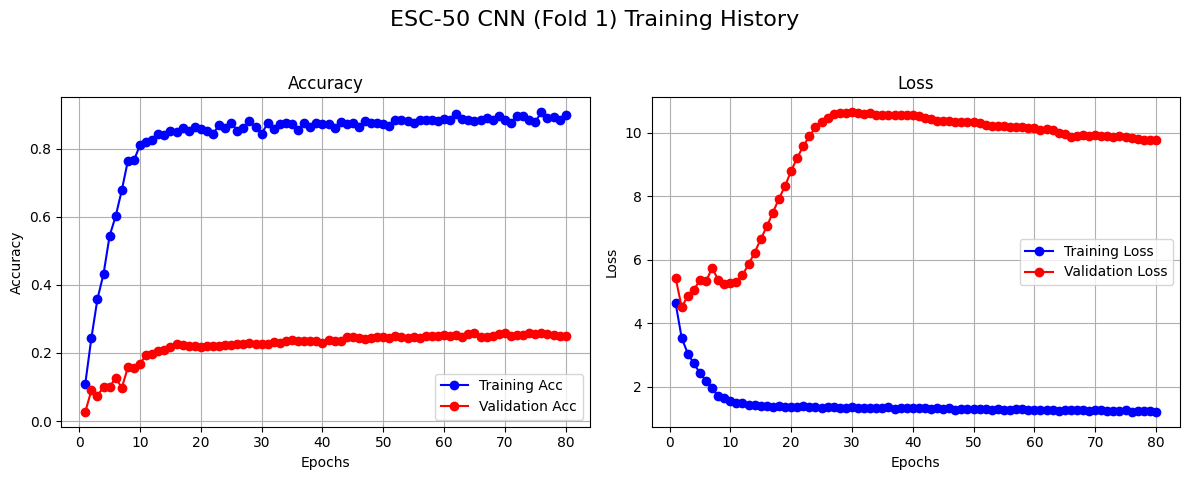


🔬 PHÂN TÍCH CHI TIẾT KẾT QUẢ TRÊN TẬP VALIDATION CỦA FOLD 1
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step

--- Báo cáo Phân loại (Validation Set - Fold 1) ---

                  precision    recall  f1-score   support

        airplane       0.00      0.00      0.00         8
       breathing       0.00      0.00      0.00         8
  brushing_teeth       0.60      0.75      0.67         8
     can_opening       1.00      0.38      0.55         8
        car_horn       0.67      0.25      0.36         8
             cat       0.33      0.12      0.18         8
        chainsaw       1.00      0.12      0.22         8
  chirping_birds       0.24      0.50      0.32         8
    church_bells       0.75      0.38      0.50         8
        clapping       1.00      0.25      0.40         8
     clock_alarm       0.67      0.25      0.36         8
      clock_tick       0.33      0.12      0.18         8
        coughing       1.00      0.25      0.40         8
             cow       0.67    

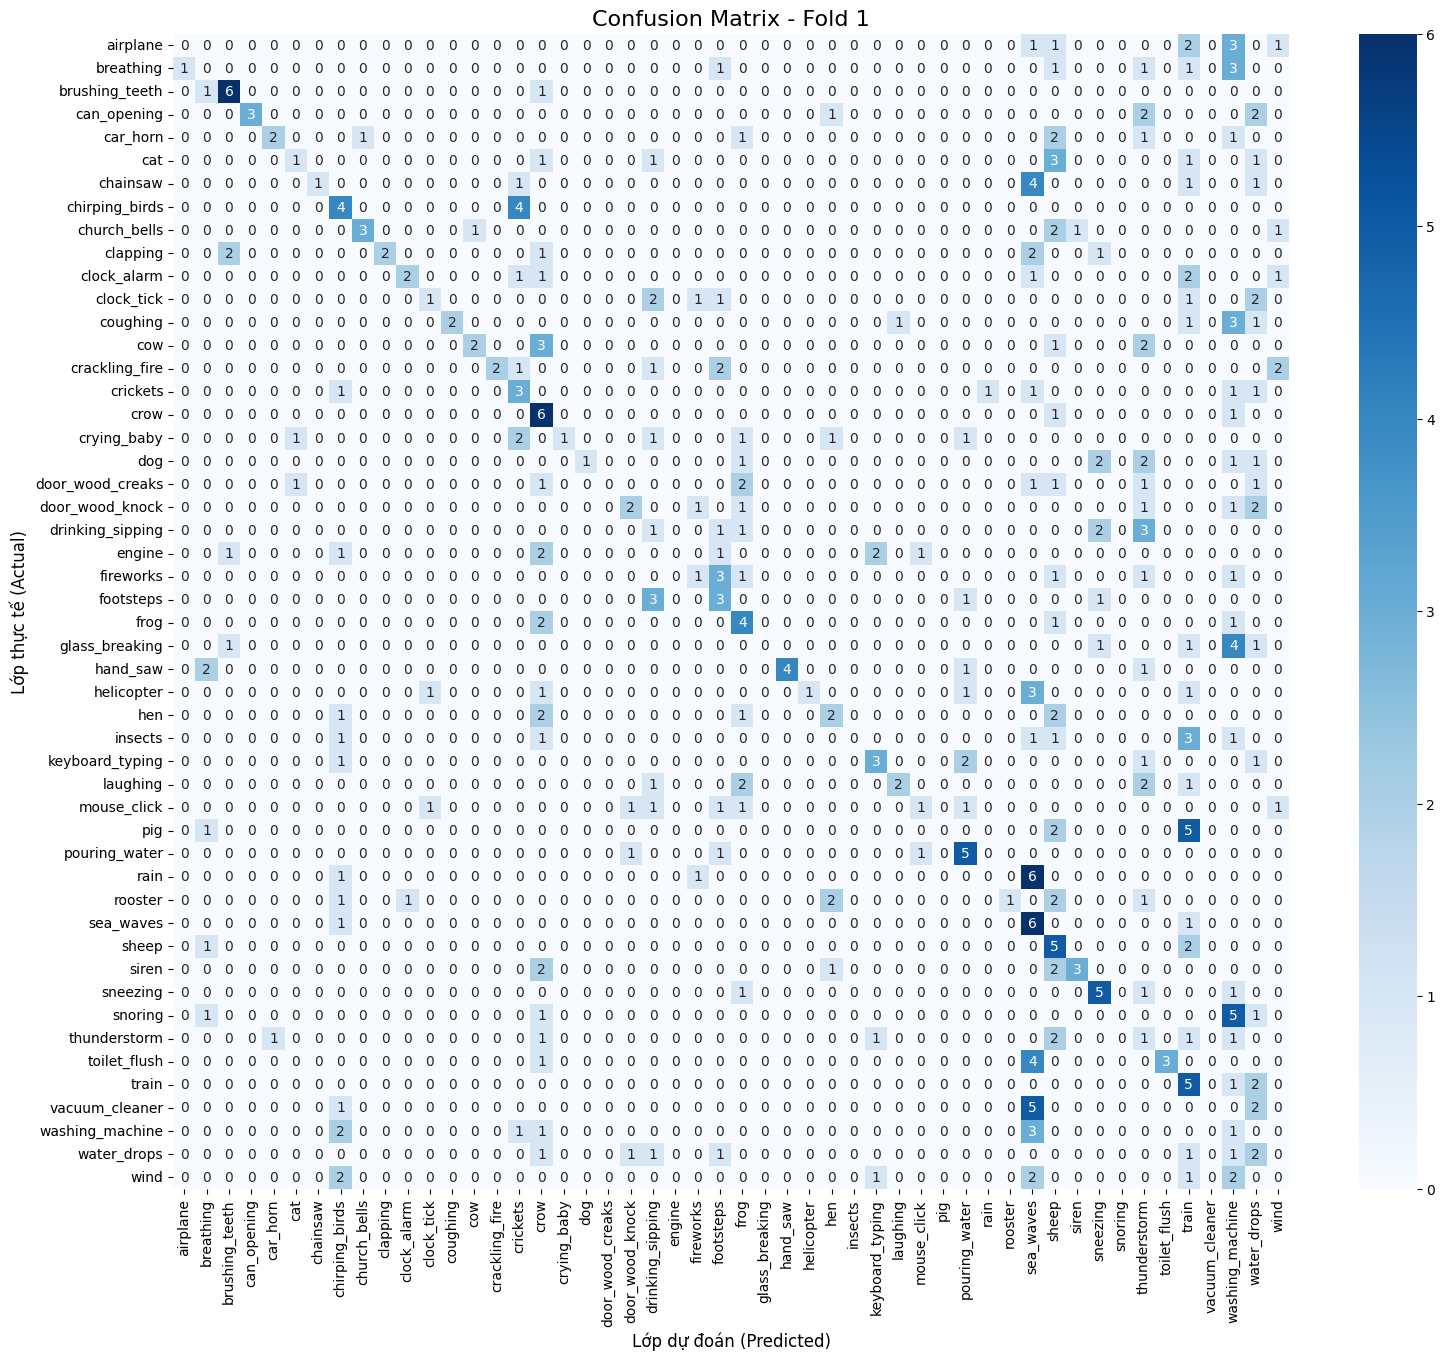

In [21]:
# Cell 18: Đánh giá bằng Plots (Lịch sử Huấn luyện & Ma trận Nhầm lẫn)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def plot_training_history(history_obj, title_prefix=""):
    """Vẽ biểu đồ Accuracy và Loss."""
    if history_obj is None or not hasattr(history_obj, 'history') or not history_obj.history:
        print(f"⚠️ Không có dữ liệu lịch sử {title_prefix} để vẽ.")
        return
    acc=history_obj.history.get('accuracy'); val_acc=history_obj.history.get('val_accuracy')
    loss=history_obj.history.get('loss'); val_loss=history_obj.history.get('val_loss')
    if not acc or not val_acc or not loss or not val_loss: print(f"⚠️ Dữ liệu lịch sử {title_prefix} bị thiếu."); return
    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5)); plt.suptitle(f'{title_prefix} Training History', fontsize=16)
    plt.subplot(1, 2, 1); plt.plot(epochs, acc, 'bo-', label='Training Acc'); plt.plot(epochs, val_acc, 'ro-', label='Validation Acc'); plt.title('Accuracy'); plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
    plt.subplot(1, 2, 2); plt.plot(epochs, loss, 'bo-', label='Training Loss'); plt.plot(epochs, val_loss, 'ro-', label='Validation Loss'); plt.title('Loss'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

# --- 1. Vẽ biểu đồ Lịch sử Huấn luyện (Ví dụ Fold 1) ---
if all_histories:
    print("\n📈 Biểu đồ Lịch sử Huấn luyện của Fold 1 (làm ví dụ):")
    plot_training_history(all_histories[0], "ESC-50 CNN (Fold 1)")
else:
    print("⚠️ Không có dữ liệu lịch sử K-Fold để vẽ.")

# --- 2. Phân tích Ma trận Nhầm lẫn (Ví dụ Fold 1) ---
ANALYSIS_FOLD = 1
model_path_to_analyze = os.path.join(OUTPUT_FOLDER, f'best_esc50_cnn_model_fold_{ANALYSIS_FOLD}.keras')

if os.path.exists(model_path_to_analyze) and df_esc50_full is not None and 'X_all_specs' in locals():
    print(f"\n🔬 PHÂN TÍCH CHI TIẾT KẾT QUẢ TRÊN TẬP VALIDATION CỦA FOLD {ANALYSIS_FOLD}")

    # Tải lại model và encoder
    best_model_to_analyze = load_model(model_path_to_analyze)
    # label_encoder_esc50_full đã được tạo ở Cell 14

    # Lấy lại dữ liệu validation của fold này
    val_df_analyze = df_esc50_full[df_esc50_full['fold'] == ANALYSIS_FOLD]
    X_val_analyze = np.array([X_all_specs[fname] for fname in val_df_analyze['filename'] if fname in X_all_specs])[..., np.newaxis]
    y_val_analyze = np.array([y_all_labels[fname] for fname in val_df_analyze['filename'] if fname in X_all_specs])

    # Dự đoán
    y_pred_probs = best_model_to_analyze.predict(X_val_analyze)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print("\n--- Báo cáo Phân loại (Validation Set - Fold 1) ---\n")
    print(classification_report(y_val_analyze, y_pred, target_names=label_encoder_esc50_full.classes_, zero_division=0))

    # Vẽ Ma trận Nhầm lẫn
    #
    print("\n--- Ma trận Nhầm lẫn (Validation Set - Fold 1) ---\n")
    cm = confusion_matrix(y_val_analyze, y_pred)
    plt.figure(figsize=(18, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder_esc50_full.classes_,
                yticklabels=label_encoder_esc50_full.classes_)
    plt.title(f'Confusion Matrix - Fold {ANALYSIS_FOLD}', fontsize=16)
    plt.ylabel('Lớp thực tế (Actual)', fontsize=12)
    plt.xlabel('Lớp dự đoán (Predicted)', fontsize=12)
    plt.xticks(rotation=90); plt.yticks(rotation=0); plt.show()
else:
    print("⚠️ Không tìm thấy model ESC-50 đã huấn luyện hoặc dữ liệu để phân tích.")

In [22]:
# Cell 19: Định nghĩa Hàm Dự đoán (Sử dụng Model CNN)

from tensorflow.keras.models import load_model

def predict_audio_events_custom_cnn(audio_path, model, encoder,
                                    sr_target, fixed_spec_shape,
                                    confidence_threshold=0.5,
                                    window_sec=5.0, step_sec=2.5,
                                    min_duration_sec=0.5):
    """
    Dự đoán sự kiện bằng model CNN đã train với cửa sổ trượt và gộp sự kiện.
    """
    print(f"🎤 Bắt đầu nhận diện sự kiện (Model CNN Tự huấn luyện)...")
    events = []
    n_mels = fixed_spec_shape[0]
    target_spec_len = fixed_spec_shape[1]

    try:
        y, sr_orig = librosa.load(audio_path, sr=sr_target, mono=True)
        duration = librosa.get_duration(y=y, sr=sr_target)

        window_samples = int(window_sec * sr_target)
        step_samples = int(step_sec * sr_target)
        num_windows = int(np.ceil((len(y) - window_samples) / step_samples)) + 1
        print(f"   (Sẽ phân tích {num_windows} cửa sổ trượt...)")

        current_event = None
        merged_events = []

        for i in range(num_windows):
            start_sample = i * step_samples
            end_sample = start_sample + window_samples
            y_slice = y[start_sample:end_sample]

            if len(y_slice) < window_samples:
                y_slice = np.pad(y_slice, (0, window_samples - len(y_slice)), mode='constant')

            # Tạo Mel Spectrogram (giống hệt Cell 15)
            mel_spec = librosa.feature.melspectrogram(y=y_slice, sr=sr_target, n_mels=n_mels)
            if mel_spec.shape[1] < target_spec_len:
                pad_width = target_spec_len - mel_spec.shape[1]
                mel_spec = np.pad(mel_spec, ((0, 0), (0, pad_width)), mode='constant')
            elif mel_spec.shape[1] > target_spec_len:
                mel_spec = mel_spec[:, :target_spec_len]

            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            spec_input = mel_spec_db[np.newaxis, ..., np.newaxis]

            # Dự đoán
            prediction = model.predict(spec_input, verbose=0)[0]
            predicted_index = np.argmax(prediction)
            confidence = prediction[predicted_index]

            window_start_sec = start_sample / sr_target
            window_end_sec = window_start_sec + window_sec

            if confidence >= confidence_threshold:
                predicted_label = encoder.inverse_transform([predicted_index])[0]

                # !!! LỌC RA CÁC LỚP KHÔNG PHẢI MÔI TRƯỜNG !!!
                # (Tùy chỉnh danh sách này dựa trên các lớp ESC-50 của bạn)
                if predicted_label not in ['speech', 'background', 'engine', 'wind']:
                    event_text = f"[{predicted_label.capitalize()}]"

                    # Gộp sự kiện (logic tương tự Cell 8)
                    if current_event is None:
                        current_event = {'start': window_start_sec, 'end': window_end_sec, 'text': event_text}
                    elif current_event['text'] == event_text:
                        current_event['end'] = window_end_sec
                    else:
                        if current_event['end'] - current_event['start'] >= min_duration_sec:
                            merged_events.append(current_event)
                        current_event = {'start': window_start_sec, 'end': window_end_sec, 'text': event_text}
            else:
                if current_event is not None:
                    if current_event['end'] - current_event['start'] >= min_duration_sec:
                        merged_events.append(current_event)
                    current_event = None

        if current_event is not None and current_event['end'] - current_event['start'] >= min_duration_sec:
            merged_events.append(current_event)

        events = merged_events
        print(f"✅ Model CNN Tự huấn luyện đã phát hiện {len(events)} sự kiện.")

    except Exception as e:
        print(f"❌ Lỗi khi dự đoán sự kiện CNN: {e}")

    return events

print("✅ Hàm predict_audio_events_custom_cnn đã sẵn sàng.")

✅ Hàm predict_audio_events_custom_cnn đã sẵn sàng.


In [23]:
# Cell 20: Chạy Inference (Sử dụng Model CNN)

print("⏳ Đang tải model CNN tốt nhất từ K-Fold (ví dụ: Fold 1)...")

# Tải lại model (chọn fold tốt nhất, ví dụ fold 1)
BEST_FOLD_MODEL_PATH = os.path.join(OUTPUT_FOLDER, 'best_esc50_cnn_model_fold_1.keras')
audio_events_esc50 = []

if os.path.exists(BEST_FOLD_MODEL_PATH) and 'label_encoder_esc50_full' in locals():
    # Tải lại file audio tạm nếu nó đã bị xóa
    if not os.path.exists(TEMP_AUDIO_PATH):
        print("⚠️ File audio tạm không tìm thấy, đang tạo lại...")
        try:
            with VideoFileClip(VIDEO_PATH_IN_DRIVE) as video:
                video.audio.write_audiofile(TEMP_AUDIO_PATH, codec='pcm_s16le', logger=None)
            print(f"✅ Đã tạo lại: {TEMP_AUDIO_PATH}")
        except Exception as e:
            print(f"❌ Lỗi khi tạo lại audio: {e}")

    if os.path.exists(TEMP_AUDIO_PATH):
        custom_model = load_model(BEST_FOLD_MODEL_PATH)

        # Chạy hàm dự đoán mới
        audio_events_esc50 = predict_audio_events_custom_cnn(
            audio_path=TEMP_AUDIO_PATH,
            model=custom_model,
            encoder=label_encoder_esc50_full,
            sr_target=SR_ESC50,
            fixed_spec_shape=FIXED_SHAPE_ESC50,
            confidence_threshold=0.15, # Bắt đầu với 50%, có thể điều chỉnh
            min_duration_sec=0.5
        )
    else:
        print("❌ Không thể chạy inference vì thiếu file audio tạm.")
else:
    print("⚠️ Không tìm thấy model ESC-50 đã huấn luyện hoặc label encoder. Hãy chạy Cell 14-17 trước.")

⏳ Đang tải model CNN tốt nhất từ K-Fold (ví dụ: Fold 1)...
⚠️ File audio tạm không tìm thấy, đang tạo lại...
✅ Đã tạo lại: temp_extracted_audio.wav
🎤 Bắt đầu nhận diện sự kiện (Model CNN Tự huấn luyện)...
   (Sẽ phân tích 35 cửa sổ trượt...)
✅ Model CNN Tự huấn luyện đã phát hiện 19 sự kiện.


In [24]:
# Cell 21: Gộp và Tạo File SRT (Phiên bản ESC-50)

# Đặt tên file output mới
OUTPUT_SRT_ESC50_PATH = os.path.join(OUTPUT_FOLDER, f"{BASE_FILENAME}_esc50_final.srt")

# Biến speech_segments đã được tạo ở Cell 3
if not speech_segments and not audio_events_esc50:
    print("⚠️ Không có phụ đề nào (Whisper hoặc ESC-50) để gộp.")
else:
    print("🔄 Đang gộp phụ đề (Whisper + ESC-50)...")
    combined_list_esc50 = speech_segments + audio_events_esc50
    all_subtitles_esc50 = sorted(combined_list_esc50, key=lambda x: x['start'])

    print(f"⏳ Đang tạo file SRT (ESC-50) tại: {OUTPUT_SRT_ESC50_PATH}")
    try:
        with open(OUTPUT_SRT_ESC50_PATH, 'w', encoding='utf-8') as f:
            for i, sub in enumerate(all_subtitles_esc50):
                end_time = max(sub['start'] + 0.1, sub['end'])
                f.write(str(i + 1) + '\n')
                # format_time_srt đã được định nghĩa ở Cell 4
                f.write(f"{format_time_srt(sub['start'])} --> {format_time_srt(end_time)}\n")
                f.write(sub['text'] + '\n\n')
        print(f"✅ Đã tạo file SRT (ESC-50) thành công!")
        files.download(OUTPUT_SRT_ESC50_PATH)
        print(f"🚀 Bắt đầu tải file '{os.path.basename(OUTPUT_SRT_ESC50_PATH)}'...")
    except Exception as e:
        print(f"❌ Lỗi khi ghi file SRT (ESC-50): {e}")

🔄 Đang gộp phụ đề (Whisper + ESC-50)...
⏳ Đang tạo file SRT (ESC-50) tại: /content/drive/MyDrive/VideoCaptionOutput/input_video_esc50_final.srt
✅ Đã tạo file SRT (ESC-50) thành công!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🚀 Bắt đầu tải file 'input_video_esc50_final.srt'...


In [26]:
# Cell Web App (ĐÃ SỬA LỖI): Web App Đồng bộ với Pipeline Chính

try:
    import gradio as gr
except ImportError:
    !pip install -q gradio
    import gradio as gr

import os
import shutil
import numpy as np
import librosa
import pandas as pd
import tensorflow_hub as hub
import whisper
from moviepy.editor import VideoFileClip, TextClip, CompositeVideoClip

# Load model YAMNet và Whisper ra ngoài để không phải load lại mỗi lần bấm nút
print("⏳ Đang khởi tạo Web App (Load Model)...")
if 'yamnet_model' not in globals():
    yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')
    class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
    yamnet_class_names = pd.read_csv(class_map_path)['display_name'].tolist()

if 'model_whisper' not in globals():
    model_whisper = whisper.load_model("base")
print("✅ Web App đã sẵn sàng!")

def ai_subtitle_pipeline(input_video_path, threshold, offset_seconds):
    """
    Pipeline xử lý video nhận từ Web App.
    """
    if input_video_path is None:
        return None, None

    print(f"\n🚀 Đang xử lý video: {input_video_path}")

    # 1. Đường dẫn tạm
    temp_audio = "temp_web_audio.wav"
    output_srt = "output_subtitles.srt"
    output_video = "output_video_captioned.mp4"

    # 2. Tách âm thanh
    try:
        with VideoFileClip(input_video_path) as video:
            video.audio.write_audiofile(temp_audio, codec='pcm_s16le', logger=None)
    except Exception as e:
        return None, f"Lỗi tách âm thanh: {str(e)}"

    # 3. Chạy Whisper (Với Offset tùy chỉnh)
    print("🤖 Đang chạy Whisper...")
    result = model_whisper.transcribe(temp_audio)
    speech_segments = [
        {'start': s['start'] + offset_seconds, 'end': s['end'] + offset_seconds, 'text': s['text'].strip()}
        for s in result['segments']
    ]

    # 4. Chạy YAMNet (Logic ĐÃ SỬA để giống Cell 8)
    print(f"🔊 Đang chạy YAMNet (Ngưỡng: {threshold})...")
    wav_data, sr = librosa.load(temp_audio, sr=16000, mono=True)
    scores, _, _ = yamnet_model(wav_data)
    scores_df = pd.DataFrame(scores.numpy(), columns=yamnet_class_names)

    # --- LOGIC LỌC SỰ KIỆN CHÍNH XÁC ---
    # 1. Định nghĩa các nhãn mục tiêu (Đã loại bỏ Speech)
    TARGET_LABELS = ['Laughter', 'Clap', 'Clapping', 'Bird', 'Birdsong', 'Rain', 'Music']

    # 2. Chỉ lấy các cột mục tiêu có trong DataFrame
    target_cols = [col for col in TARGET_LABELS if col in scores_df.columns]

    audio_events = []
    if target_cols:
        # 3. Lọc các frame có giá trị > threshold
        high_confidence_frames = scores_df[target_cols] > threshold

        current_event = None
        min_duration = 0.2 # Giữ min duration thấp như đã tinh chỉnh
        step_sec = 0.48

        for i in range(len(high_confidence_frames)):
            frame_start = i * step_sec
            frame_end = frame_start + step_sec

            top_event = None
            # Nếu có bất kỳ sự kiện mục tiêu nào vượt ngưỡng
            if high_confidence_frames.iloc[i].any():
                # Lấy sự kiện cao nhất TRONG SỐ CÁC MỤC TIÊU (Bỏ qua Speech ở đây)
                top_event_label = scores_df[target_cols].iloc[i].idxmax()
                top_event = f"[{top_event_label.capitalize()}]"

            if top_event:
                if current_event is None:
                    current_event = {'start': frame_start, 'end': frame_end, 'text': top_event}
                elif current_event['text'] == top_event:
                    current_event['end'] = frame_end
                else:
                    if current_event['end'] - current_event['start'] >= min_duration:
                        audio_events.append(current_event)
                    current_event = {'start': frame_start, 'end': frame_end, 'text': top_event}
            else:
                if current_event:
                    if current_event['end'] - current_event['start'] >= min_duration:
                        audio_events.append(current_event)
                    current_event = None
        if current_event and (current_event['end'] - current_event['start'] >= min_duration):
            audio_events.append(current_event)

    print(f"✅ YAMNet tìm thấy {len(audio_events)} sự kiện.")

    # 5. Gộp và Tạo SRT
    all_subs = sorted(speech_segments + audio_events, key=lambda x: x['start'])

    with open(output_srt, 'w', encoding='utf-8') as f:
        for i, sub in enumerate(all_subs):
            def fmt(s):
                ms = int((s - int(s)) * 1000)
                m, s = divmod(int(s), 60)
                h, m = divmod(m, 60)
                return f"{h:02d}:{m:02d}:{s:02d},{ms:03d}"
            # Đảm bảo duration tối thiểu cho hiển thị
            end_time = max(sub['start'] + 0.5, sub['end'])
            f.write(f"{i+1}\n{fmt(sub['start'])} --> {fmt(end_time)}\n{sub['text']}\n\n")

    # 6. Overlay Video (Nếu hàm có sẵn)
    if 'overlay_subtitles_on_video' in globals():
        # Dùng try-except để tránh sập web app nếu lỗi overlay
        try:
            overlay_subtitles_on_video(input_video_path, all_subs, output_video)
        except Exception as e:
            print(f"⚠️ Lỗi Overlay: {e}")
            return None, output_srt # Trả về SRT nếu video lỗi
    else:
        return None, output_srt

    return output_video, output_srt

# --- GIAO DIỆN WEB ---
with gr.Blocks(title="AI Subtitles", theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🎬 AI Video Captioning (Whisper + YAMNet)")

    with gr.Row():
        with gr.Column():
            video_in = gr.Video(label="Input Video")
            thresh_slider = gr.Slider(0.05, 0.5, value=0.1, label="Độ nhạy YAMNet (Threshold)")
            offset_slider = gr.Slider(0.0, 1.0, value=0.2, label="Độ trễ lời thoại (Offset giây)")
            btn = gr.Button("🚀 Chạy Xử Lý", variant="primary")
        with gr.Column():
            video_out = gr.Video(label="Kết quả Video")
            file_out = gr.File(label="Tải file SRT")

    btn.click(ai_subtitle_pipeline, [video_in, thresh_slider, offset_slider], [video_out, file_out])

demo.launch(share=True, debug=True)

  with gr.Blocks(title="AI Subtitles", theme=gr.themes.Soft()) as demo:



⏳ Đang khởi tạo Web App (Load Model)...
✅ Web App đã sẵn sàng!
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://602a68c172173a81cb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",


🚀 Đang xử lý video: /tmp/gradio/55ea6c6d741eca7ec5885a9cd5f887f0bbfe2a9c8fbd47e3c4036e332e13d4f1/input_video.mp4
🤖 Đang chạy Whisper...
🔊 Đang chạy YAMNet (Ngưỡng: 0.1)...
✅ YAMNet tìm thấy 7 sự kiện.
🎬 Đang chuẩn bị overlay phụ đề lên video...
🎞️ Video gốc: 640x480, Duration: 87.91s
💬 Tổng số phụ đề cần overlay: 45

🔄 Đang ghép các clip (Render)...
💾 Đang xuất video ra file: output_video_captioned.mp4...


  warnings.warn("Warning: in file %s, "%(self.filename)+

  warnings.warn("Warning: in file %s, "%(self.filename)+



🎉 Đã tạo video mới thành công (28.42 giây).
Lưu tại: output_video_captioned.mp4
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://602a68c172173a81cb.gradio.live
